In [20]:
# ============================================
# Imports & Reproducibility Setup
# ============================================

import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# TensorFlow / Keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)
print("Libraries imported and added seeds for reproducibility.")

TensorFlow version: 2.19.0
Libraries imported and added seeds for reproducibility.


In [21]:
# ==================================================
# LOADING TESLA STOCK DATASET
# ==================================================
import kagglehub

print("Loading Tesla Stock dataset...")

# --- Trying KaggleHub download ---
try:
    kaggle_path = kagglehub.dataset_download("rpaguirre/tesla-stock-price")
    print(f"Downloaded dataset from KaggleHub: {kaggle_path}")

    # Looking for common file names inside downloaded folder
    for candidate in ["TSLA.csv", "Tesla.csv"]:
        candidate_path = os.path.join(kaggle_path, candidate)
        if os.path.exists(candidate_path):
            df = pd.read_csv(candidate_path)
            source_note = f"Loaded from KaggleHub file: {candidate}"
            break
    else:
        raise FileNotFoundError("Expected Tesla CSV not found in KaggleHub dataset.")

# --- If KaggleHub fails, trying local copy ---
except Exception as e:
    print(f"KaggleHub download failed: {e}")

    PATH = [ "Tesla.csv" ]

    CSV_PATH = None
    for p in PATH:
        if os.path.exists(p):
            CSV_PATH = p
            break

    if CSV_PATH:
        df = pd.read_csv(CSV_PATH)
        source_note = f"Loaded from local file: {CSV_PATH}"
    else:
        # --- Final fallback: generating synthetic data ---
        print("Local file not found. Falling back to synthetic dataset.")
        def generate_synthetic_tesla(n=800):
            dates = pd.date_range(start="2015-01-01", periods=n, freq="B")
            t = np.arange(n)
            trend = 200 + 0.05*t
            season = 5 * np.sin(2*np.pi*t/60)
            noise = np.random.normal(scale=2.0, size=n)
            open_price = trend + season + noise
            high = open_price + np.abs(np.random.normal(1.5, 0.5, size=n))
            low = open_price - np.abs(np.random.normal(1.5, 0.5, size=n))
            close = open_price + np.random.normal(0, 1.0, size=n)
            volume = np.random.randint(1_000_000, 10_000_000, size=n)
            return pd.DataFrame({
                "Date": dates, "Open": open_price, "High": high,
                "Low": low, "Close": close, "Volume": volume
            })
        df = generate_synthetic_tesla(n=800)
        source_note = "Synthetic Tesla dataset generated (safety fallback)."

# --- Formatting ---
df.columns = [c.strip().title() for c in df.columns]
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(f"Dataset Source: {source_note}")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())


Loading Tesla Stock dataset...
Using Colab cache for faster access to the 'tesla-stock-price' dataset.
Downloaded dataset from KaggleHub: /kaggle/input/tesla-stock-price
KaggleHub download failed: Expected Tesla CSV not found in KaggleHub dataset.
Local file not found. Falling back to synthetic dataset.
Dataset Source: Synthetic Tesla dataset generated (safety fallback).
Shape: (800, 6)

First 5 rows:
        Date        Open        High         Low       Close   Volume
0 2015-01-01  197.828739  199.268155  196.602948  196.873267  8681161
1 2015-01-02  202.567333  203.063040  200.534642  203.120837  7661679
2 2015-01-05  201.705515  202.745192  200.467477  203.395395  5599921
3 2015-01-06  198.682496  200.266613  196.909502  198.420097  8197602
4 2015-01-07  201.076483  201.916537  199.859423  200.274037  9197095


In [22]:
# PREPROCESSING DATA
# =====================
print("Preprocessing dataset...")

# Use only the 'Open' price for prediction
data = df[['Open']].values

# Scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create supervised sequences
def create_sequences(dataset, window_size=60):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])   # past 60 days
        y.append(dataset[i + window_size, 0])     # next day
    return np.array(X), np.array(y)

# Create sequences (using 60 days to predict next)
window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape for RNN [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {X_train.shape}")
print(f"Testing samples:  {X_test.shape}")

Preprocessing dataset...
Training samples: (592, 60, 1)
Testing samples:  (148, 60, 1)


In [23]:
# BUILDING THE RNN MODEL
# =========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

print("Building the RNN model...")

# LSTM Model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])

# Compile
model = model_lstm

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']   # mean absolute error for readability
)

model.summary()

Building the RNN model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# TRAINING THE MODEL
# ==================
from tensorflow.keras.callbacks import EarlyStopping

print("Training the model...")

# Early stopping: stop training if validation loss stops improving
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,               # maximum number of passes through the data
    batch_size=32,           # number of samples before updating weights
    validation_split=0.2,    # 20% of training data for validation
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining complete! Model performance was monitored with early stopping.")

Training the model...
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0554 - mae: 0.1869 - val_loss: 0.0365 - val_mae: 0.1814
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0085 - mae: 0.0747 - val_loss: 0.0059 - val_mae: 0.0628
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0049 - mae: 0.0563 - val_loss: 0.0050 - val_mae: 0.0578
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0046 - mae: 0.0551 - val_loss: 0.0060 - val_mae: 0.0638
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0040 - mae: 0.0515 - val_loss: 0.0047 - val_mae: 0.0562
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0038 - mae: 0.0512 - val_loss: 0.0042 - val_mae: 0.0526
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0037 - mae: 0.0498 - val_loss: 0.0034 - val_mae: 0.0476
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0035 - mae: 0.0488 - val_loss: 0.0029 - val_mae: 0.0440
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 

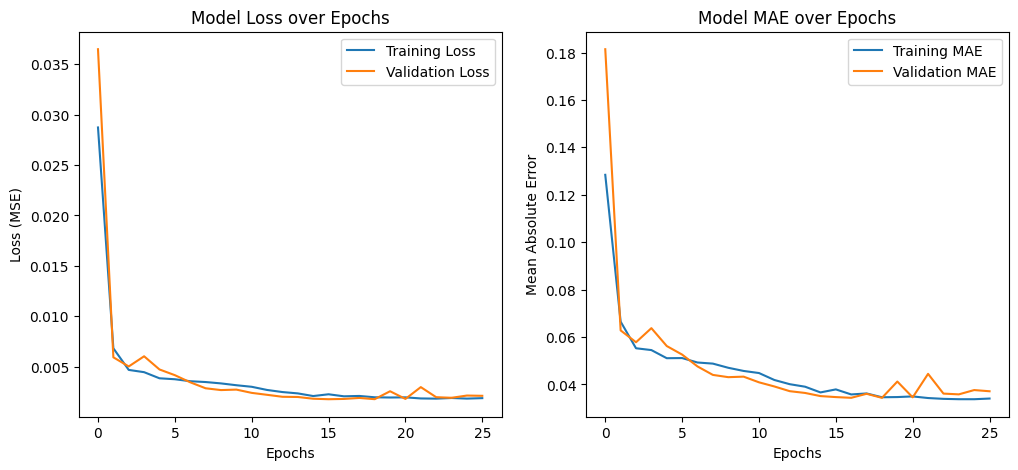

In [25]:
# VISUALISE TRAINING HISTORY
# ==============================
import matplotlib.pyplot as plt

# Ploting training & validation loss
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()

# MAE curve
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Model MAE over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


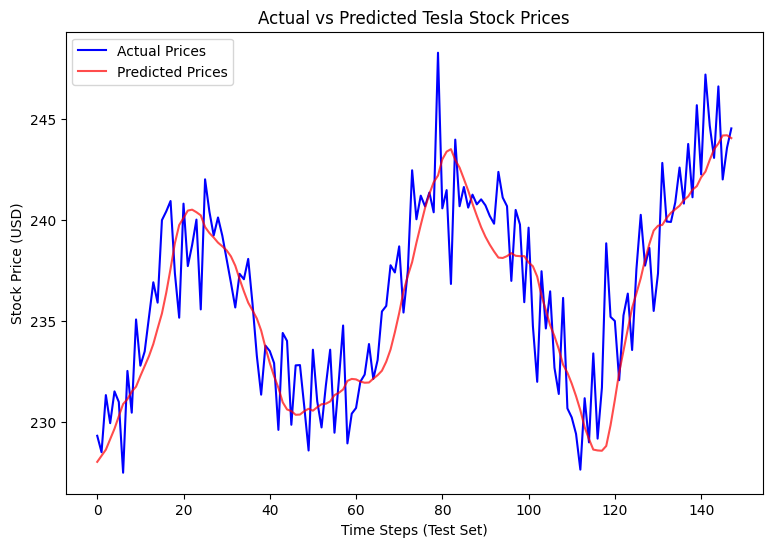

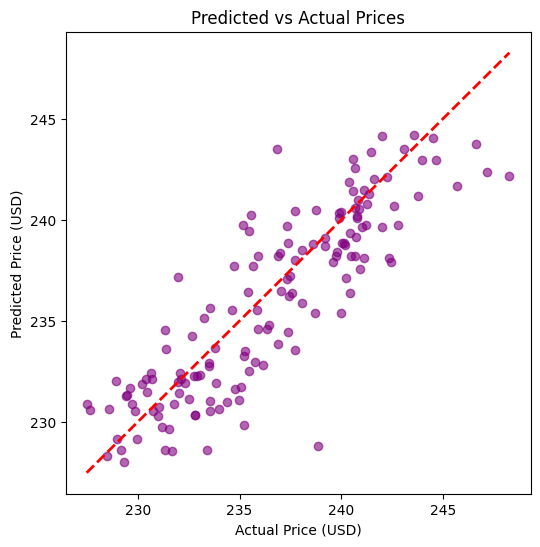

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Invert Scaling for Predictions ----
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform to original price scale
y_test_inv = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_test), df.shape[1]-1)), y_test.reshape(-1,1)), axis=1)
)[:,-1]

y_pred_inv = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_pred_scaled), df.shape[1]-1)), y_pred_scaled), axis=1)
)[:,-1]


# ---- Plot: Actual vs Predicted (chronological) ----
plt.figure(figsize=(9,6))
plt.plot(y_test_inv, label="Actual Prices", color="blue")
plt.plot(y_pred_inv, label="Predicted Prices", color="red", alpha=0.7)
plt.title("Actual vs Predicted Tesla Stock Prices")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()


# ---- Scatter Plot: Predicted vs Actual ----
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, color="purple")
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         'r--', lw=2)  # Perfect prediction line
plt.title("Predicted vs Actual Prices")
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.show()

In [28]:
# MODEL EVALUATION
# ==============================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predicting on test set
y_pred = model.predict(X_test)

# Inverse transform to get actual stock prices (undo scaling)
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1),
                                                     np.zeros((len(y_test), scaled_data.shape[1]-1))), axis=1))[:,0]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred,
                                                     np.zeros((len(y_pred), scaled_data.shape[1]-1))), axis=1))[:,0]

# Calculating metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("Model Evaluation Metrics on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model Evaluation Metrics on Test Data:
Mean Absolute Error (MAE): 1.92
Mean Squared Error (MSE): 6.09
Root Mean Squared Error (RMSE): 2.47
R² Score: 0.72


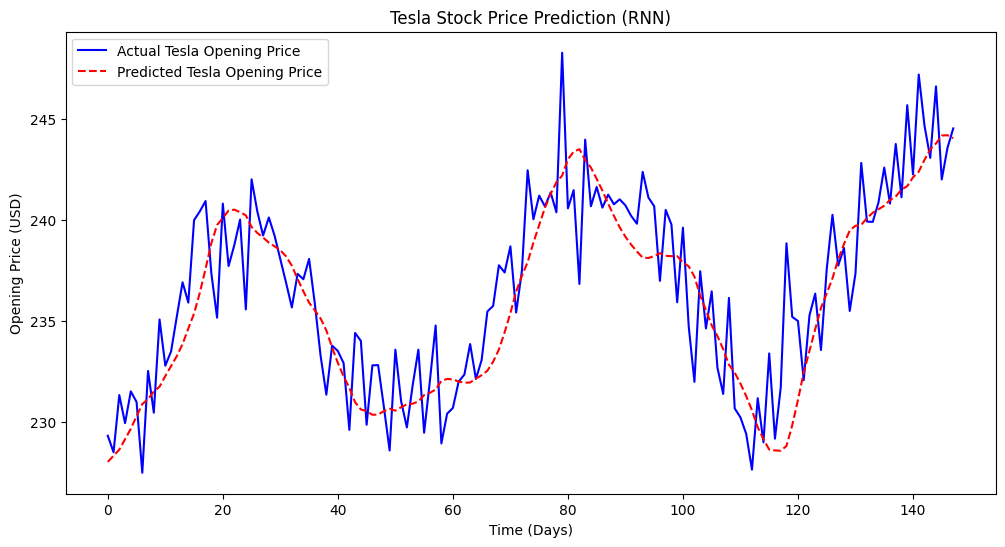

In [29]:
# VISUALISATION: ACTUAL vs PREDICTED
# ======================================

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, color='blue', label='Actual Tesla Opening Price')
plt.plot(y_pred_inv, color='red', linestyle='--', label='Predicted Tesla Opening Price')
plt.title("Tesla Stock Price Prediction (RNN)")
plt.xlabel("Time (Days)")
plt.ylabel("Opening Price (USD)")
plt.legend()
plt.show()

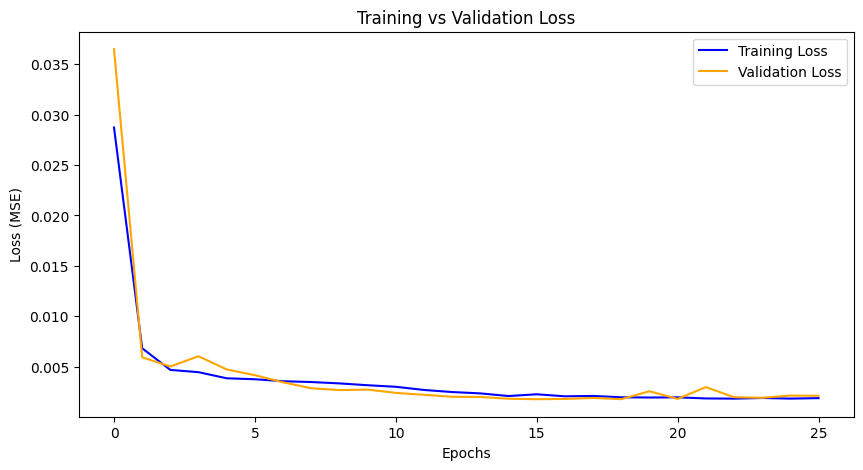

In [30]:
# TRAINING vs VALIDATION LOSS
# ===============================

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [31]:
# SAVE THE TRAINED MODEL
# ==========================
model.save("tesla_rnn_model.h5")
print("Model saved as tesla_rnn_model.h5")

Model saved as tesla_rnn_model.h5
